In [132]:
%run -i /bioinformatics/Glasslib/GlassTools.py
# GENERATE THE 2000bp version of the original  KC-H_KC_N_H3k27ac_at_peaks.txt
#cmd=annotatePeaks.pl mergePeaks_C57_NoTx_Tim4Pos20wkNASH.txt mm10 -d KC-H_Rep1 KC-H_Rep2 KC-N_Rep1 KC_N_Rep2)

Group1='MASH'
Group2='HEALTHY'
baseDir='/home/psaisan/MCAT/'


# Input File: ATAC PEAKS Combined from HEALTHY and MASH cells
C57_ATAC_KCHN=baseDir+"/data/ATAC_Kupffer_HEALTHY_and_MASH_Peaks_200bp.txt"

# Output ehancer peak FILE Names for after being loaded H3k27ac ChIP Tags
h3k_KCH_KCN_tags_2000=baseDir+'data/KC-H_KC_N_H3k27ac_at_peaks_w2000.txt'
h3k_KCH_KCN_tags_1000=baseDir+'data/KC-H_KC_N_H3k27ac_at_peaks_w1000.txt' 


# ChIP-Seq Replicates for HEALTHY cells
KC_H_Rep1=baseDir+"/data/ChIP_HEALTHY_Rep1"
KC_H_Rep2=baseDir+"/data/ChIP_HEALTHY_Rep2"

# ChIP-Seq Replicates for HEALTHY cells
KC_N_Rep1=baseDir+"/data/ChIP_MASH_Rep1"
KC_N_Rep2=baseDir+"/data/ChIP_MASH_Rep2"

 
# LOAD ATAC PEAKS with H3K27ac ChIP-tags from HEALTHY and MASH ChIPs using HOMER's annotatePeaks
!annotatePeaks.pl $C57_ATAC_KCHN mm10 -d $KC_H_Rep1 $KC_H_Rep2 $KC_N_Rep1 $KC_N_Rep2 -size 1000 > $h3k_KCH_KCN_tags_1000\


	Peak file = /home/psaisan/MCAT//data/ATAC_Kupffer_HEALTHY_and_MASH_Peaks_200bp.txt
	Genome = mm10
	Organism = mouse
	Tag Directories:
		/home/psaisan/MCAT//data/ChIP_HEALTHY_Rep1
		/home/psaisan/MCAT//data/ChIP_HEALTHY_Rep2
		/home/psaisan/MCAT//data/ChIP_MASH_Rep1
		/home/psaisan/MCAT//data/ChIP_MASH_Rep2
	Peak Region set to 1000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 70300
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 70300
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Annotating:........................
		Annotation	Number of peaks	Total size (bp)	Log2 Ratio (obs/exp)	LogP enrichment (+values depleted)
		3UTR	788.0	20049228	0.

In [133]:
# 3
#######################
#
# Calculate differentially acetylated regions using DESeq2 via 'getDiffExpression.pl' (FC > 2, p-adj < 0.05). 
# H3K27ac ChIP-seq signal around distal ATAC-seq peaks in a 1,000 bp window. 
# Regions overlapping with KC signature enhancers are colored green. 
# Enhancers (peaks) with more acetylation during NASH are colored red
# Enhancers (peaks) less acetylation during NASH are colored blue. 
# 
# Define Input and output file names for getDiffExpression(infile,outfile)
#
 

input_file_wtwtkoko=h3k_KCH_KCN_tags_1000
output_file_getDiffExp='/home/psaisan/MCAT/h3K_tags_khkh_knkn_w1000.txt' #      '~/PEAKS/hoxb8_ATAC_diff_h3k27ac_peaks_wtwt_koko1.txt'

cmd = 'getDiffExpression.pl {infile} WT WT KO KO -log2fold 1 -raw > {outfile}'.format(infile=input_file_wtwtkoko,outfile=output_file_getDiffExp)
printr(cmd) 

!$cmd



getDiffExpression.pl /home/psaisan/MCAT/KC-H_KC_N_H3k27ac_at_peaks_w1000.txt WT WT KO KO -log2fold 1 -raw > /home/psaisan/MCAT/h3K_tags_khkh_knkn_w1000.txt
	Autodetecting input file format...
	Autodetected annotatePeaks.pl file
	Will report raw counts in output table (no normalization)


	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats WT vs. KO:
		Total Genes: 70300
		Total Up-regulated in KO vs. WT: 3717 (5.287%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in KO vs. WT: 2678 (3.809%) [log2fold<-1, FDR<0.05]



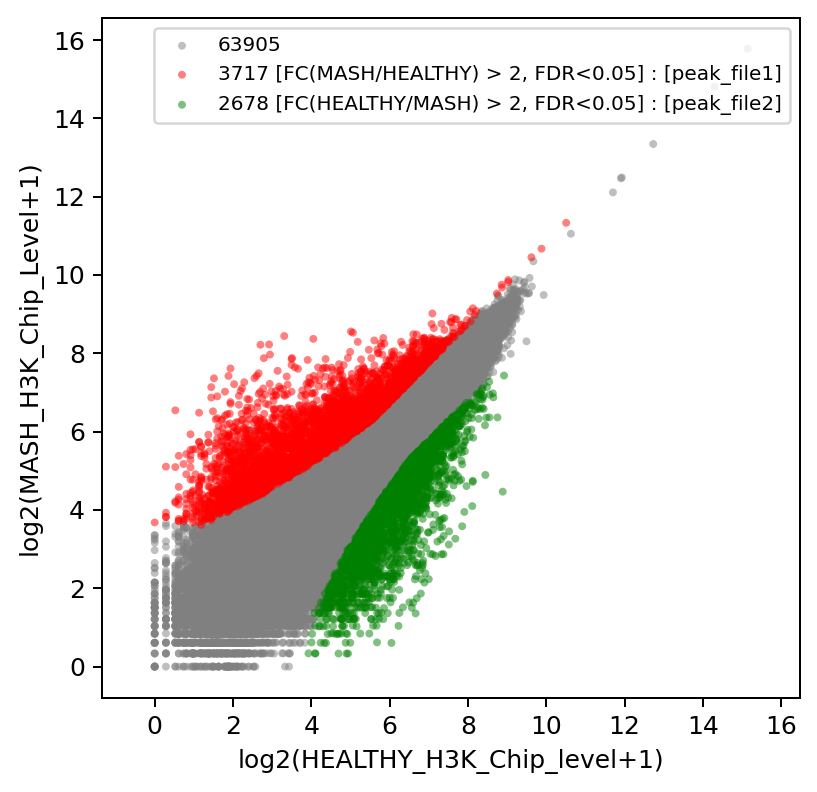

In [144]:
#######################
# 7
#######################

# Read getDiffExpression outfile, Define Normal HEALTHY vs Altered MASH conditions, 
# PLOT scatter seperable segments

# Uncomment below to read df and df_scatter:
df2       =   pd.read_csv(getDiffExp_outfile,sep='\t')

 
FC_Col=23 # Fold change olumn
WT_Col=19 # HEALTHY H327Kac column1
KO_Col=21 # MASH H327Kac column1
p_val_Col=25 # P-Value column


# fdata =  is Log2FoldChange WT/KO or KO/WT
fdata = df2.iloc[:, FC_Col]
fdata = pd.to_numeric(fdata, errors='coerce')

pdata = df2.iloc[:, p_val_Col]
pdata = pd.to_numeric(pdata, errors='coerce')



# Define the 3 conditions for segmentation of enhancers (peaks)
cond1=(fdata >=  1) & (pdata < 0.05)  # (Log2FC  > 1 ) means MASH H3k27ac level >= HEALTHY H3k27ac level
cond2=(fdata <= -1) & (pdata < 0.05)  # (Log2FC  < -1 ) means MASH H3k27ac level <= HEALTHY H3k27ac level
cond3 = ~(cond1 | cond2)




# Extrac H3K27AC densities for MASH assuming 2 columns -otherwise you need to modify below
ydata = (df2.iloc[:, KO_Col]+df2.iloc[:, KO_Col+1])/2  # Replace 2 with the desired column index
ydata = pd.to_numeric(ydata, errors='coerce')


# Extrac H3K27AC densities for HEALTHY assuming 2 columns -otherwise you need to modify below
xdata = (df2.iloc[:, WT_Col]+ df2.iloc[:, WT_Col+1])/2 # Replace 2 with the desired column index
xdata = pd.to_numeric(xdata, errors='coerce')
 


# Plot H3K27AC Tag density as a function of distance to peak-center for KO and WT
plt.figure(figsize=(5, 5), dpi=180)

# Plot condition 3 : grey  
plt.scatter(
    np.log2(1 + xdata[cond3]),
    np.log2(ydata[cond3] + 1),
    color=[0.5,0.5,0.5],
    alpha=0.5,  # Set transparency to 50%
    label=f"{len(xdata[cond3])}",
    edgecolors='none',  # Remove edge colors for better blending
    s=10  # Adjust marker size as needed
)


# Plot condition 1 : red  
plt.scatter(
    np.log2(1 + xdata[cond1]),
    np.log2(ydata[cond1] + 1),
    color='r',  # Changed from 'c' to 'color'
    alpha=0.5,  # Set transparency to 50%
    label=f"{len(xdata[cond1])} [FC({Group1}/{Group2}) > 2, FDR<0.05] : [peak_file1]",
    edgecolors='none',
    s=10
)

# Plot condition 2 with green 
plt.scatter(
    np.log2(1 + xdata[cond2]),
    np.log2(ydata[cond2] + 1),
    color='g',  # Changed from 'c' to 'color'
    alpha=0.5,  # Set transparency to 50%
    label=f"{len(xdata[cond2])} [FC({Group2}/{Group1}) > 2, FDR<0.05] : [peak_file2]",
    edgecolors='none',
    s=10
)







plt.xlabel(f'log2({Group2}_H3K_Chip_level+1)')  # KCH -> Group2
plt.ylabel(f'log2({Group1}_H3K_Chip_Level+1)')  # KCN -> Group1

plt.xlim(0,7)
plt.ylim(0,7)
plt.axis('equal')


plt.legend(fontsize=8)
plt.show()

In [145]:
# 8
#############################
# SAVE cond1 and cond2 Peaks
cond1_file='/home/psaisan/MCAT/KCN_H3K_FC2_1000.txt'
cond2_file='/home/psaisan/MCAT/KCH_H3K_FC2_1000.txt'
df2[cond1].to_csv(cond1_file, sep='\t', index=False)
df2[cond2].to_csv(cond2_file, sep='\t', index=False)

,[1][PeakID (cmd=annotatePeaks.pl /home/psaisan/MCAT//data/ATAC_Kupffer_HEALTHY_and_MASH_Peaks_200bp.txt mm10 -d /home/psaisan/MCAT//data/ChIP_HEALTHY_Rep1 /home/psaisan/MCAT//data/ChIP_HEALTHY_Rep2 /home/psaisan/MCAT//data/ChIP_MASH_Rep1 /home/psaisan/MCAT//data/ChIP_MASH_Rep2 -size 1000) (cmd=getDiffExpression.pl /home/psaisan/MCAT/KC-H_KC_N_H3k27ac_at_peaks_w1000.txt WT WT KO KO -log2fold 1 -raw)],[2][Chr],[3][Start],[4][End],[5][Strand],...,"[22][/home/psaisan/MCAT//data/ChIP_MASH_Rep1 Tag Count in 1000 bp (18749728.0 Total, normalization factor = 0.53, effective total = 10000000)]","[23][/home/psaisan/MCAT//data/ChIP_MASH_Rep2 Tag Count in 1000 bp (19231109.0 Total, normalization factor = 0.52, effective total = 10000000)]",[24][WT vs. KO Log2 Fold Change],[25][WT vs. KO p-value],[26][WT vs. KO adj. p-value]
1379,[1] Merged-chr5-123125791-1,[2] chr5,[3] 123125291,[4] 123126291,[5] +,...,[22] 17.07,[23] 16.12,[24] 2.49192924243092,[25] 0.006608805188879,[26] 0.0499920660533287
1373,[1] Merged-chr2-79619190-2,[2] chr2,[3] 79618690,[4] 79619690,[5] +,...,[22] 34.67,[23] 32.76,[24] 1.53107692579633,[25] 0.0065782723803036,[26] 0.049816652076343
3150,[1] Merged-chr7-130886452-1,[2] chr7,[3] 130885952,[4] 130886952,[5] +,...,[22] 26.13,[23] 14.04,[24] 2.23852179843785,[25] 0.0065732737736519,[26] 0.0498030742252536
2583,[1] Merged-chr13-5785655-2,[2] chr13,[3] 5785155,[4] 5786155,[5] +,...,[22] 48.0,[23] 37.44,[24] 1.4122414703401,[25] 0.0065714292445515,[26] 0.0498002252544852
2150,[1] Merged-chr15-5244764-1,[2] chr15,[3] 5244264,[4] 5245264,[5] +,...,[22] 17.6,[23] 23.4,[24] 2.16448077596245,[25] 0.0065607377886996,[26] 0.0497386897915955
...,...,...,...,...,...,...,...,...,...,...,...
2508,[1] Merged-chr7-117470287-1,[2] chr7,[3] 117469787,[4] 117470787,[5] +,...,[22] 294.94,[23] 301.59,[24] 5.76965558424475,[25] 2.57520596905573e-35,[26] 2.49052461277328e-31
457,[1] Merged-chr2-34963581-1,[2] chr2,[3] 34963081,[4] 34964081,[5] +,...,[22] 400.54,[23] 334.87,[24] 3.73905517661598,[25] 7.86675049245509e-40,[26] 9.12967861651383e-36
2754,[1] Merged-chr1-166138358-2,[2] chr1,[3] 166137858,[4] 166138858,[5] +,...,[22] 352.01,[23] 307.31,[24] 4.6564606927409,[25] 3.73464175193044e-41,[26] 5.41775142348169e-37
2494,[1] Merged-chr4-150061017-2,[2] chr4,[3] 150060517,[4] 150061517,[5] +,...,[22] 375.47,[23] 317.71,[24] 5.51140581835355,[25] 2.41282245563517e-41,[26] 4.66696162110473e-37


(3717,)
0.0499920660533287


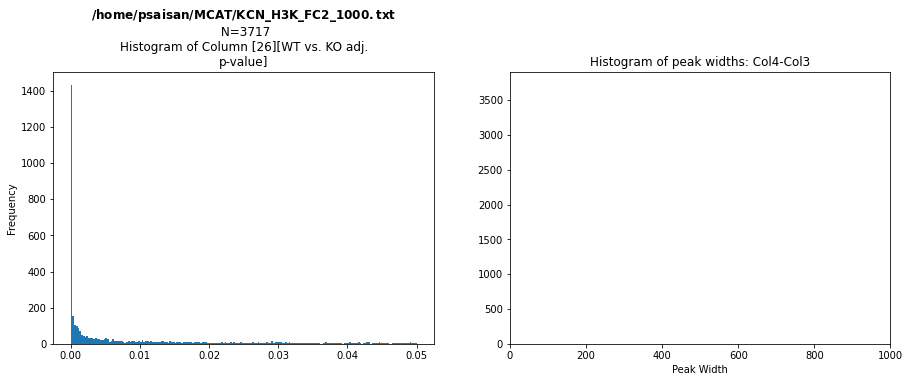

,[1][PeakID (cmd=annotatePeaks.pl /home/psaisan/MCAT//data/ATAC_Kupffer_HEALTHY_and_MASH_Peaks_200bp.txt mm10 -d /home/psaisan/MCAT//data/ChIP_HEALTHY_Rep1 /home/psaisan/MCAT//data/ChIP_HEALTHY_Rep2 /home/psaisan/MCAT//data/ChIP_MASH_Rep1 /home/psaisan/MCAT//data/ChIP_MASH_Rep2 -size 1000) (cmd=getDiffExpression.pl /home/psaisan/MCAT/KC-H_KC_N_H3k27ac_at_peaks_w1000.txt WT WT KO KO -log2fold 1 -raw)],[2][Chr],[3][Start],[4][End],[5][Strand],...,"[22][/home/psaisan/MCAT//data/ChIP_MASH_Rep1 Tag Count in 1000 bp (18749728.0 Total, normalization factor = 0.53, effective total = 10000000)]","[23][/home/psaisan/MCAT//data/ChIP_MASH_Rep2 Tag Count in 1000 bp (19231109.0 Total, normalization factor = 0.52, effective total = 10000000)]",[24][WT vs. KO Log2 Fold Change],[25][WT vs. KO p-value],[26][WT vs. KO adj. p-value]
1379,Merged-chr5-123125791-1,chr5,123125291,123126291,+,...,17.07,16.12,2.49192924243092,0.006608805188879,4.999207e-02
1373,Merged-chr2-79619190-2,chr2,79618690,79619690,+,...,34.67,32.76,1.53107692579633,0.0065782723803036,4.981665e-02
3150,Merged-chr7-130886452-1,chr7,130885952,130886952,+,...,26.13,14.04,2.23852179843785,0.0065732737736519,4.980307e-02
2583,Merged-chr13-5785655-2,chr13,5785155,5786155,+,...,48.0,37.44,1.4122414703401,0.0065714292445515,4.980023e-02
2150,Merged-chr15-5244764-1,chr15,5244264,5245264,+,...,17.6,23.4,2.16448077596245,0.0065607377886996,4.973869e-02
...,...,...,...,...,...,...,...,...,...,...,...
2508,Merged-chr7-117470287-1,chr7,117469787,117470787,+,...,294.94,301.59,5.76965558424475,2.57520596905573e-35,2.490525e-31
457,Merged-chr2-34963581-1,chr2,34963081,34964081,+,...,400.54,334.87,3.73905517661598,7.86675049245509e-40,9.129679e-36
2754,Merged-chr1-166138358-2,chr1,166137858,166138858,+,...,352.01,307.31,4.6564606927409,3.73464175193044e-41,5.417751e-37
2494,Merged-chr4-150061017-2,chr4,150060517,150061517,+,...,375.47,317.71,5.51140581835355,2.41282245563517e-41,4.666962e-37


In [146]:
displayPeak(cond1_file,'[26]')
#displayPeak(cond1_file)

In [117]:
##########################
# Motif Analysis of :
# 1) Up_In_KO ATAC Peaks (Down in WT)
# 2) Down_In_KO ATAC Peaks (UP in WT)

#displayPeak('/nfstest/DAM_ANALYSIS/PEAKS/hoxb8_ATAC_diff_h3k27ac_peaks_UP_FC2.txt')
motif_out_UP='/homer_data/www/html/GlassLab/MOTIFS/up_in_KCN_H3K27ac_w400/'
getMotifs(cond1_file,motif_out_UP,options=' -size -190,190   -len 8,10,12,14,16 ',force_write=True)

#displayPeak('/nfstest/DAM_ANALYSIS/PEAKS/hoxb8_ATAC_diff_h3k27ac_peaks_UP_FC2.txt')
motif_out_DOWN='/homer_data/www/html/GlassLab/MOTIFS/down_in_KCN_H3K27ac_w400/'
getMotifs(cond2_file,motif_out_DOWN,options=' -size -190,190  -len 8,10,12,14,16 ', force_write=True)


	Position file = /home/psaisan/MCAT/KCN_H3K_FC2_1000.txt
	Genome = mm10
	Output Directory = /homer_data/www/html/GlassLab/MOTIFS/up_in_KCN_H3K27ac_w400/
	Using 20 CPUs
	Using regions from -190 to 190 relative to peak centers
	Fragment size set to 380
	Motif length set at 8,10,12,14,*** might want to hit ctrl+C to quit if it takes too long!
*** If you run out of memmory try reducing the number background sequences
16,*** might want to hit ctrl+C to quit if it takes too long!
*** If you run out of memmory try reducing the number background sequences

	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 3717

	Peak File Statistics:
		Total Peaks: 3717
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks go

		57 of 428 (1e-24) Nrf2(bZIP)/Lymphoblast-Nrf2-ChIP-Seq(GSE37589)/Homer
		58 of 428 (1e-24) Egr1(Zf)/K562-Egr1-ChIP-Seq(GSE32465)/Homer
		59 of 428 (1e-24) Tgif1(Homeobox)/mES-Tgif1-ChIP-Seq(GSE55404)/Homer
		60 of 428 (1e-23) Mef2d(MADS)/Retina-Mef2d-ChIP-Seq(GSE61391)/Homer
		61 of 428 (1e-23) Atf4(bZIP)/MEF-Atf4-ChIP-Seq(GSE35681)/Homer
		62 of 428 (1e-22) CLOCK(bHLH)/Liver-Clock-ChIP-Seq(GSE39860)/Homer
		63 of 428 (1e-21) Tgif2(Homeobox)/mES-Tgif2-ChIP-Seq(GSE55404)/Homer
		64 of 428 (1e-20) NFAT:AP1(RHD,bZIP)/Jurkat-NFATC1-ChIP-Seq(Jolma_et_al.)/Homer
		65 of 428 (1e-20) RUNX2(Runt)/PCa-RUNX2-ChIP-Seq(GSE33889)/Homer
		66 of 428 (1e-19) MafK(bZIP)/C2C12-MafK-ChIP-Seq(GSE36030)/Homer
		67 of 428 (1e-19) Mef2b(MADS)/HEK293-Mef2b.V5-ChIP-Seq(GSE67450)/Homer
		68 of 428 (1e-19) MafA(bZIP)/Islet-MafA-ChIP-Seq(GSE30298)/Homer
		69 of 428 (1e-18) Mef2a(MADS)/HL1-Mef2a.biotin-ChIP-Seq(GSE21529)/Homer
		70 of 428 (1e-17) CRE(bZIP)/Promoter/Homer
		71 of 428 (1e-17) Foxo1(Forkhead)/RAW-Fo

		179 of 428 (1e-2) PAX3:FKHR-fusion(Paired,Homeobox)/Rh4-PAX3:FKHR-ChIP-Seq(GSE19063)/Homer
		180 of 428 (1e-2) Max(bHLH)/K562-Max-ChIP-Seq(GSE31477)/Homer
		181 of 428 (1e-2) Hoxa10(Homeobox)/ChickenMSG-Hoxa10.Flag-ChIP-Seq(GSE86088)/Homer
		182 of 428 (1e-2) FOXK1(Forkhead)/HEK293-FOXK1-ChIP-Seq(GSE51673)/Homer
		183 of 428 (1e-2) ZNF768(Zf)/Rajj-ZNF768-ChIP-Seq(GSE111879)/Homer
		184 of 428 (1e-2) HIF-1b(HLH)/T47D-HIF1b-ChIP-Seq(GSE59937)/Homer
		185 of 428 (1e-2) ZBTB18(Zf)/HEK293-ZBTB18.GFP-ChIP-Seq(GSE58341)/Homer
	----------------------------------------------------------
	De novo motif finding (HOMER)

	Number of Trial motifs (-T) set to 20 (from 10) to work well with 20 CPUs
	Scanning input files...
	Parsing sequences...
	|0%                                   50%                                  100%|
	Total number of Oligos: 32896
	Autoadjustment for sequence coverage in background: 1.00x

	Oligos: 32896 of 34497 max
	Tree  : 67084 of 172485 max
	Optimizing memory usage...
	

		Reprioritizing potential motifs...
	17 of 25 Initial Sequence: AGTGTGTA... (-21.414)
		Round 1: -21.41 AGTGTGTA T:120.0(3.18%),B:793.8(1.71%),P:1e-9
		Round 2: -21.41 AGTGTGTA T:120.0(3.18%),B:793.8(1.71%),P:1e-9
		=Final=: -19.63 AGTGTGTA T:110.0(2.96%),B:739.5(1.61%),P:1e-8
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	18 of 25 Initial Sequence: AGTCACCG... (-20.011)
		Round 1: -54.19 AGTCACCG T:1787.0(38.17%),B:16601.6(30.36%),P:1e-23
		Round 2: -71.40 AGTCACHV T:2287.0(45.96%),B:20898.4(36.59%),P:1e-31
		Round 3: -71.40 AGTCACHV T:2287.0(45.96%),B:20898.4(36.59%),P:1e-31
		=Final=: -77.74 AGTCACHV T:1518.0(40.84%),B:14375.1(31.34%),P:1e-33
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	19 of 25 Initial Sequence: TTGCTCAA... (-18.639)
		Round 1: -24.85 TTGCTCAM T:193.0(5.06%),B:1404.2(3.01%),P:1e-10
		Round 2: -29.76 TTACTCAA T:184.0(4.83%),B:1237.5(2.66%),P:1e-12
		Round 3: -29.76 TTACTCAA T:184.0(4.83%),B:123

	9 of 25 Initial Sequence: ATGACGTCAT... (-114.784)
		Round 1: -147.37 ATGACGTCAT T:563.0(14.06%),B:2975.9(6.28%),P:1e-64
		Round 2: -163.98 ATGASGTCAT T:992.0(23.43%),B:6216.8(12.67%),P:1e-71
		Round 3: -163.98 ATGASGTCAT T:992.0(23.43%),B:6216.8(12.67%),P:1e-71
		=Final=: -151.76 ATGASGTCAT T:837.0(22.52%),B:5657.4(12.33%),P:1e-65
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	10 of 25 Initial Sequence: CTTGCCATAT... (-112.253)
		Round 1: -112.25 CTTGCCATAT T:50.0(1.34%),B:26.1(0.06%),P:1e-48
		Round 2: -112.25 CTTGCCATAT T:50.0(1.34%),B:26.1(0.06%),P:1e-48
		=Final=: -57.14 CTTGCCATAT T:31.0(0.83%),B:26.1(0.06%),P:1e-24
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	11 of 25 Initial Sequence: GTCACATGAC... (-85.093)
		Round 1: -158.49 GTCACATGAC T:1014.0(23.88%),B:6484.2(13.18%),P:1e-68
		Round 2: -159.77 RTCACATGAC T:956.0(22.68%),B:5985.7(12.23%),P:1e-69
		Round 3: -159.77 RTCACATGAC T:956.0(22.68%),B:5985.7(12.

		78.86% skipped, 21.14% checked (1097362 of 5190729), of those checked:
		78.86% not in target, 0.00% increased p-value, 0.00% high p-value

	Screening oligos 5190729 (allowing 1 mismatches):
	|0%                                   50%                                  100%|
		78.86% skipped, 21.14% checked (1097362 of 5190729), of those checked:
		0.00% not in target, 16.30% increased p-value, 4.41% high p-value

	Screening oligos 5190729 (allowing 2 mismatches):
	|0%                                   50%                                  100%|
		95.96% skipped, 4.04% checked (209758 of 5190729), of those checked:
		0.00% not in target, 2.07% increased p-value, 0.00% high p-value
	Reading input files...
	49999 total sequences read
	Cache length = 11180
	Using binomial scoring

	Local Optimization Phase:
	1 of 25 Initial Sequence: ATATTCCACGTC... (-350.250)
		Round 1: -540.77 ATATTCCAGGTC T:101.0(2.68%),B:3.9(0.01%),P:1e-234
		Round 2: -540.77 ATATTCCAGGTC T:101.0(2.68%),B:3.9(0.01%),P:1

		Round 1: -17.32 DNCKGAGTCAHS T:2042.0(42.27%),B:21865.9(37.91%),P:1e-7
		Round 2: -17.32 DNCKGAGTCAHS T:2042.0(42.27%),B:21865.9(37.91%),P:1e-7
		=Final=: -13.31 DNCKGAGTCAHS T:1866.0(50.20%),B:21276.3(46.38%),P:1e-5
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	19 of 25 Initial Sequence: CTATTTTTAGCA... (-45.702)
		Round 1: -57.55 CTATTTTTAGCA T:139.0(3.67%),B:597.0(1.29%),P:1e-24
		Round 2: -63.49 CTATTTTTAGCA T:109.0(2.89%),B:370.0(0.80%),P:1e-27
		Round 3: -66.57 CTATTTTTAGCA T:174.0(4.57%),B:783.1(1.69%),P:1e-28
		Round 4: -66.57 CTATTTTTAGCA T:174.0(4.57%),B:783.1(1.69%),P:1e-28
		=Final=: -66.81 CTATTTTTAGCA T:169.0(4.55%),B:767.5(1.67%),P:1e-29
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	20 of 25 Initial Sequence: CCCCGCCCGCCC... (-45.375)
		Round 1: -46.22 CCCCGCCCGCCC T:1560.0(34.28%),B:14639.3(27.32%),P:1e-20
		Round 2: -48.98 CCCCGCCCGCCC T:761.0(18.52%),B:6359.5(12.94%),P:1e-21
		Round 3: -48.98 CC

		Reprioritizing potential motifs...
	8 of 25 Initial Sequence: TTTTCAGTGATTTC... (-132.580)
		Round 1: -223.63 TTTTCAGTGATTTC T:43.0(1.15%),B:1.5(0.00%),P:1e-97
		Round 2: -223.63 TTTTCAGTGATTTC T:43.0(1.15%),B:1.5(0.00%),P:1e-97
		=Final=: -150.24 TTTTCAGTGATTTC T:30.0(0.81%),B:1.5(0.00%),P:1e-65
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	9 of 25 Initial Sequence: CGTCTGCGTCTGCG... (-103.896)
		Round 1: -126.76 CGTCTGCSTCTGCG T:27.0(0.72%),B:1.7(0.00%),P:1e-55
		Round 2: -126.76 CGTCTGCSTCTGCG T:27.0(0.72%),B:1.7(0.00%),P:1e-55
		=Final=: -21.73 CGTCTGCSTCTGCG T:6.0(0.16%),B:1.7(0.00%),P:1e-9
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	10 of 25 Initial Sequence: ATTTCTCATTTTTC... (-66.875)
		Round 1: -112.62 ATTTCTCATTTTTC T:30.0(0.80%),B:4.9(0.01%),P:1e-48
		Round 2: -112.62 ATTTCTCATTTTTC T:30.0(0.80%),B:4.9(0.01%),P:1e-48
		=Final=: -77.90 ATTTCTCATTTTTC T:23.0(0.62%),B:4.9(0.01%),P:1e-33
		Performing exh

	Output in file: /homer_data/www/html/GlassLab/MOTIFS/up_in_KCN_H3K27ac_w400//homerMotifs.motifs14


	Number of Trial motifs (-T) set to 20 (from 10) to work well with 20 CPUs
	-blen automatically set to 3
	Scanning input files...
	Parsing sequences...
	|0%                                   50%                                  100%|
	Total number of Oligos: 16225341
	Autoadjustment for sequence coverage in background: 1.00x

	Oligos: 16225341 of 18299634 max
	Tree  : 47995536 of 91498170 max
	Optimizing memory usage...
	Cache length = 11180
	Using binomial scoring

	Global Optimization Phase: Looking for enriched oligos with up to 2 mismatches...

	Screening oligos 16225341 (allowing 0 mismatches):
	|0%                                   50%                                  100%|
		91.82% skipped, 8.18% checked (1327416 of 16225341), of those checked:
		91.82% not in target, 0.00% increased p-value, 0.00% high p-value

	Screening oligos 16225341 (allowing 1 mismatches):
	|0%            

		Round 2: -17.75 TKTTTCTCATTYTCAA T:16.0(0.43%),B:29.9(0.06%),P:1e-7
		Round 3: -26.19 CGTTTCCCATTCTGCA T:8.0(0.22%),B:2.1(0.00%),P:1e-11
		Round 4: -30.79 TGWTTCYCATTYTCMA T:9.0(0.24%),B:2.5(0.00%),P:1e-13
		Round 5: -30.79 TGWTTCYCATTYTCMA T:9.0(0.24%),B:2.5(0.00%),P:1e-13
		=Final=: -45.23 TGWTTCYCATTYTCMA T:11.0(0.30%),B:0.7(0.00%),P:1e-19
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	17 of 25 Initial Sequence: AAAGCAGAAGTGAAAG... (-31.595)
		Round 1: -53.55 AAAGCAGAAGTGAAAG T:20.0(0.54%),B:7.8(0.02%),P:1e-23
		Round 2: -61.10 AAAGCAGAAGTGAAAG T:20.0(0.54%),B:5.8(0.01%),P:1e-26
		Round 3: -66.27 AAAGSAGAAGTGAVWS T:275.0(7.13%),B:1556.5(3.34%),P:1e-28
		Round 4: -90.31 AAAGGAGAAGTGAGAG T:68.0(1.81%),B:94.6(0.20%),P:1e-39
		Round 5: -90.31 AAAGGAGAAGTGAGAG T:68.0(1.81%),B:94.6(0.20%),P:1e-39
		=Final=: -83.50 AAAGGAGAAGTGAGAG T:65.0(1.75%),B:97.5(0.21%),P:1e-36
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	18 of

/bioinformatics/homer/bin/findMotifsGenome.pl /home/psaisan/MCAT/KCN_H3K_FC2_1000.txt mm10 /homer_data/www/html/GlassLab/MOTIFS/up_in_KCN_H3K27ac_w400/ -cpu 20   -size -190,190   -len 8,10,12,14,16 
MOTIFS generated and saved in '/homer_data/www/html/GlassLab/MOTIFS/up_in_KCN_H3K27ac_w400/'.



	Position file = /home/psaisan/MCAT/KCH_H3K_FC2_1000.txt
	Genome = mm10
	Output Directory = /homer_data/www/html/GlassLab/MOTIFS/down_in_KCN_H3K27ac_w400/
	Using 20 CPUs
	Using regions from -190 to 190 relative to peak centers
	Fragment size set to 380
	Motif length set at 8,10,12,14,*** might want to hit ctrl+C to quit if it takes too long!
*** If you run out of memmory try reducing the number background sequences
16,*** might want to hit ctrl+C to quit if it takes too long!
*** If you run out of memmory try reducing the number background sequences

	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 2678

	Peak File Statistics:
		Total Peaks: 2678
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks 

		55 of 428 (1e-10) Bach2(bZIP)/OCILy7-Bach2-ChIP-Seq(GSE44420)/Homer
		56 of 428 (1e-10) IRF4(IRF)/GM12878-IRF4-ChIP-Seq(GSE32465)/Homer
		57 of 428 (1e-10) Sp2(Zf)/HEK293-Sp2.eGFP-ChIP-Seq(Encode)/Homer
		58 of 428 (1e-10) Atf4(bZIP)/MEF-Atf4-ChIP-Seq(GSE35681)/Homer
		59 of 428 (1e-10) c-Jun-CRE(bZIP)/K562-cJun-ChIP-Seq(GSE31477)/Homer
		60 of 428 (1e-9) MafB(bZIP)/BMM-Mafb-ChIP-Seq(GSE75722)/Homer
		61 of 428 (1e-9) NFkB-p65(RHD)/GM12787-p65-ChIP-Seq(GSE19485)/Homer
		62 of 428 (1e-8) c-Myc(bHLH)/LNCAP-cMyc-ChIP-Seq(Unpublished)/Homer
		63 of 428 (1e-8) ETS:RUNX(ETS,Runt)/Jurkat-RUNX1-ChIP-Seq(GSE17954)/Homer
		64 of 428 (1e-8) Fosl2(bZIP)/3T3L1-Fosl2-ChIP-Seq(GSE56872)/Homer
		65 of 428 (1e-8) bHLHE41(bHLH)/proB-Bhlhe41-ChIP-Seq(GSE93764)/Homer
		66 of 428 (1e-8) Esrrb(NR)/mES-Esrrb-ChIP-Seq(GSE11431)/Homer
		67 of 428 (1e-7) FXR(NR),IR1/Liver-FXR-ChIP-Seq(Chong_et_al.)/Homer
		68 of 428 (1e-7) JunB(bZIP)/DendriticCells-Junb-ChIP-Seq(GSE36099)/Homer
		69 of 428 (1e-7) Fra2(bZIP)/S

		=Final=: -163.80 TTCCGCTT T:1235.0(46.12%),B:13932.6(29.67%),P:1e-71
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	3 of 25 Initial Sequence: GTGACCTC... (-50.543)
		Round 1: -83.76 GTGACCTC T:1867.0(50.21%),B:22523.8(38.10%),P:1e-36
		Round 2: -83.76 GTGACCTC T:1867.0(50.21%),B:22523.8(38.10%),P:1e-36
		=Final=: -80.57 GTGACCTC T:1310.0(48.92%),B:17428.6(37.12%),P:1e-34
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	4 of 25 Initial Sequence: TGTCCTGT... (-38.233)
		Round 1: -52.58 TGTCCTGT T:299.0(10.57%),B:2706.8(5.60%),P:1e-22
		Round 2: -56.04 TGTCATGT T:366.0(12.78%),B:3473.8(7.13%),P:1e-24
		Round 3: -56.04 TGTCATGT T:366.0(12.78%),B:3473.8(7.13%),P:1e-24
		=Final=: -22.28 TGTCATGT T:275.0(10.27%),B:3278.3(6.98%),P:1e-9
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	5 of 25 Initial Sequence: AGTCAGCA... (-33.816)
		Round 1: -48.09 AGTCAGCA T:314.0(11.07%),B:2994.9(6.18%),P:1

		=Final=: -18.38 AGGCGTCA T:69.0(2.58%),B:566.8(1.21%),P:1e-7
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...

	Finalizing Enrichment Statistics (new in v3.4)
	Reading input files...
	50000 total sequences read
	Cache length = 11180
	Using binomial scoring
	Checking enrichment of 25 motif(s)
	|0%                                    50%                                  100%|
	Output in file: /homer_data/www/html/GlassLab/MOTIFS/down_in_KCN_H3K27ac_w400//homerMotifs.motifs8


	Number of Trial motifs (-T) set to 20 (from 10) to work well with 20 CPUs
	Scanning input files...
	Parsing sequences...
	|0%                                   50%                                  100%|
	Total number of Oligos: 518860
	Autoadjustment for sequence coverage in background: 1.00x

	Oligos: 518860 of 551887 max
	Tree  : 1060892 of 2759435 max
	Optimizing memory usage...
	Cache length = 11180
	Using binomial scoring

	Global Optimization Phase: Looking for enriched oligos

		Round 2: -25.09 CTACTGTATA T:16.0(0.60%),B:24.7(0.05%),P:1e-10
		=Final=: -26.97 CTACTGTATA T:16.0(0.60%),B:24.7(0.05%),P:1e-11
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	15 of 25 Initial Sequence: CGGAAATAGC... (-19.096)
		Round 1: -29.36 CGGAAATAGC T:289.0(10.23%),B:3150.5(6.49%),P:1e-12
		Round 2: -29.36 CGGAAATAGC T:289.0(10.23%),B:3150.5(6.49%),P:1e-12
		=Final=: -33.53 CGGAAATAGC T:281.0(10.49%),B:3032.8(6.46%),P:1e-14
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	16 of 25 Initial Sequence: CGCGCGCGCG... (-18.802)
		Round 1: -27.06 CGCGCGCGCG T:254.0(9.05%),B:2739.3(5.67%),P:1e-11
		Round 2: -34.53 CGCGCGCGCG T:212.0(7.61%),B:1998.2(4.17%),P:1e-14
		Round 3: -36.21 CGCGCGCGCR T:163.0(5.91%),B:1377.3(2.89%),P:1e-15
		Round 4: -37.24 CGCGCGCGCR T:143.0(5.20%),B:1128.4(2.37%),P:1e-16
		Round 5: -37.24 CGCGCGCGCR T:143.0(5.20%),B:1128.4(2.37%),P:1e-16
		=Final=: -13.81 CGCGCGCGCR T:59.0(2.20%),B:518.1(1.10%)

		=Final=: -11.96 CCTAACCTCTAA T:4.0(0.15%),B:2.5(0.01%),P:1e-5
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	4 of 25 Initial Sequence: ACTTCTGCTTCT... (-50.598)
		Round 1: -77.99 ACTTCTGCTTCT T:57.0(2.11%),B:107.6(0.23%),P:1e-33
		Round 2: -85.01 ACTTCTGCTTCT T:62.0(2.29%),B:116.5(0.25%),P:1e-36
		Round 3: -93.67 ACTTCTGCTTCT T:66.0(2.43%),B:117.9(0.25%),P:1e-40
		Round 4: -93.67 ACTTCTGCTTCT T:66.0(2.43%),B:117.9(0.25%),P:1e-40
		=Final=: -34.28 ACTTCTGCTTCT T:136.0(5.08%),B:1122.2(2.39%),P:1e-14
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	5 of 25 Initial Sequence: CTCCTGCAGCTA... (-45.691)
		Round 1: -47.02 CTCCTGCAGCTA T:16.0(0.60%),B:6.2(0.01%),P:1e-20
		Round 2: -50.10 CTCCTGCACCTA T:15.0(0.56%),B:4.9(0.01%),P:1e-21
		Round 3: -50.10 CTCCTGCACCTA T:15.0(0.56%),B:4.9(0.01%),P:1e-21
		=Final=: -10.44 CTCCTGCACCTA T:5.0(0.19%),B:6.2(0.01%),P:1e-4
		Performing exhaustive masking of motif...
		Reprioritizing pot

		Round 2: -28.26 GTGAGAAGAGGG T:17.0(0.63%),B:23.6(0.05%),P:1e-12
		=Final=: -16.31 GTGAGAAGAGGG T:10.0(0.37%),B:17.5(0.04%),P:1e-7
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	24 of 25 Initial Sequence: ATTTAGGGAAGT... (-23.097)
		Round 1: -42.18 ATTTAGGGAAGT T:216.0(7.75%),B:1901.9(3.97%),P:1e-18
		Round 2: -42.90 ATTTWGGGAAGT T:146.0(5.31%),B:1085.4(2.28%),P:1e-18
		Round 3: -44.24 ATTTWGGGAAGT T:245.0(8.74%),B:2220.5(4.62%),P:1e-19
		Round 4: -51.27 WTTTWGGGAAGT T:512.0(17.41%),B:5484.7(11.02%),P:1e-22
		Round 5: -67.72 DDTKWGGGAAGT T:639.0(21.23%),B:6663.1(13.23%),P:1e-29
		Round 6: -68.48 DNTKWGGGAAST T:500.0(17.03%),B:4867.5(9.85%),P:1e-29
		Round 7: -68.48 DNTKWGGGAAST T:500.0(17.03%),B:4867.5(9.85%),P:1e-29
		=Final=: -68.59 DNTKWGGGAAST T:458.0(17.10%),B:4648.7(9.90%),P:1e-29
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	25 of 25 Initial Sequence: TTCTGATTGGAT... (-22.640)
		Round 1: -29.85 TTCTGATTGGAT

		Round 2: -69.68 TGCTATGGGGAAGT T:382.0(13.30%),B:3390.7(6.97%),P:1e-30
		Round 3: -100.35 TGCTNTGGGGAAGT T:1105.0(33.81%),B:11692.6(22.04%),P:1e-43
		Round 4: -114.32 TGCTATGGGGAAGT T:741.0(24.18%),B:6777.2(13.44%),P:1e-49
		Round 5: -127.31 DGCTNTGGGGAAGT T:1137.0(34.60%),B:11276.9(21.35%),P:1e-55
		Round 6: -133.09 DGCTHTGRGGAAGT T:984.0(30.75%),B:9259.5(17.90%),P:1e-57
		Round 7: -133.09 DGCTHTGRGGAAGT T:984.0(30.75%),B:9259.5(17.90%),P:1e-57
		=Final=: -160.05 DGCTHTGRGGAAGT T:842.0(31.44%),B:8162.5(17.38%),P:1e-69
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	14 of 25 Initial Sequence: TCCCCCTGGGTCAG... (-29.631)
		Round 1: -54.43 TCCCCCTGGGTCAG T:13.0(0.48%),B:2.6(0.00%),P:1e-23
		Round 2: -54.43 TCCCCCTGGGTCAG T:13.0(0.48%),B:2.6(0.00%),P:1e-23
		=Final=: -15.74 TCCCCCTGGGTCAG T:5.0(0.19%),B:2.6(0.01%),P:1e-6
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	15 of 25 Initial Sequence: TCAGACCAGCTCCT... (-28.63

		Reprioritizing potential motifs...
	2 of 25 Initial Sequence: GGTGACTGTGGGTGAC... (-82.300)
		Round 1: -99.74 GGTGACTDTGGGTGAC T:21.0(0.78%),B:1.6(0.00%),P:1e-43
		Round 2: -105.66 GGTGACAATGGGTGCC T:22.0(0.82%),B:2.6(0.00%),P:1e-45
		Round 3: -105.66 GGTGACAATGGGTGCC T:22.0(0.82%),B:2.6(0.00%),P:1e-45
		=Final=: -14.68 GGTGACAATGGGTGCC T:4.0(0.15%),B:0.6(0.00%),P:1e-6
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	3 of 25 Initial Sequence: AGTGGTCACAGGACAG... (-76.881)
		Round 1: -102.75 AGTGGTCACAGGACAG T:31.0(1.15%),B:8.3(0.02%),P:1e-44
		Round 2: -102.75 AGTGGTCACAGGACAG T:31.0(1.15%),B:8.3(0.02%),P:1e-44
		=Final=: -43.81 AGTGGTCACAGGACAG T:10.0(0.37%),B:0.9(0.00%),P:1e-19
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	4 of 25 Initial Sequence: TTCTGCTTCTGCTTCT... (-73.270)
		Round 1: -122.82 TTCTDCTTCTRCTTCT T:43.0(1.59%),B:17.7(0.04%),P:1e-53
		Round 2: -122.82 TTCTDCTTCTRCTTCT T:43.0(1.59%),B:17.7(0.04%),P:

		Round 2: -55.01 TGACCCARAGYRACAT T:88.0(3.23%),B:399.9(0.85%),P:1e-23
		Round 3: -55.01 TGACCCARAGYRACAT T:88.0(3.23%),B:399.9(0.85%),P:1e-23
		=Final=: -51.44 TGACCCARAGYRACAT T:69.0(2.58%),B:279.0(0.59%),P:1e-22
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	24 of 25 Initial Sequence: CTCTTCTCACCCCAGT... (-21.041)
		Round 1: -30.11 CTCTTCTCAVCCCAGT T:11.0(0.41%),B:5.5(0.01%),P:1e-13
		Round 2: -30.11 CTCTTCTCAVCCCAGT T:11.0(0.41%),B:5.5(0.01%),P:1e-13
		=Final=: -15.74 CTCTTCTCAVCCCAGT T:5.0(0.19%),B:2.5(0.01%),P:1e-6
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	25 of 25 Initial Sequence: ACCACAGTGAACTTCC... (-20.286)
		Round 1: -61.78 ACCACAGTGAACTTCC T:1427.0(41.31%),B:17668.0(31.36%),P:1e-26
		Round 2: -74.90 AMCWCWGWGAACTTCC T:464.0(15.91%),B:4277.5(8.71%),P:1e-32
		Round 3: -91.83 HMVHCWGDGMACTTCC T:833.0(26.74%),B:8480.7(16.52%),P:1e-39
		Round 4: -91.83 HMVHCWGDGMACTTCC T:833.0(26.74%),B:8480.7(16.52%),P

/bioinformatics/homer/bin/findMotifsGenome.pl /home/psaisan/MCAT/KCH_H3K_FC2_1000.txt mm10 /homer_data/www/html/GlassLab/MOTIFS/down_in_KCN_H3K27ac_w400/ -cpu 20   -size -190,190  -len 8,10,12,14,16 
MOTIFS generated and saved in '/homer_data/www/html/GlassLab/MOTIFS/down_in_KCN_H3K27ac_w400/'.


,[1][PeakID (cmd=annotatePeaks.pl mergePeaks_C57_NoTx_Tim4Pos20wkNASH.txt mm10 -raw -size 2000 -d c57_NoTx_Rep1 c57_NoTx_Rep2 c57_Tim4Pos20WkNASH_Rep1 c57_Tim4Pos20WkNASH_Rep2) (cmd=getDiffExpression.pl ann_H3K27AC_2000_mergePeaks_C57_NoTx_Tim4Pos20wkNASH_enhancer_3000.txt NoTx NoTx Tim4Pos20wkNASH Tim4Pos20wkNASH -peaks -simpleNorm -export getDiff_ann_H3K27AC_2000_mergePeaks_C57_NoTx_Tim4Pos20wkNASH_enhancer_3000)],[2][Chr],[3][Start],[4][End],[5][Strand],...,"[22][c57_Tim4Pos20WkNASH_Rep1 Tag Count in 2000 bp (18749728.0 Total, normalization factor = 1, effective total = 10000000)]","[23][c57_Tim4Pos20WkNASH_Rep2 Tag Count in 2000 bp (19231109.0 Total, normalization factor = 1, effective total = 10000000)]",[24][NoTx vs. Tim4Pos20wkNASH Log2 Fold Change],[25][NoTx vs. Tim4Pos20wkNASH p-value],[26][NoTx vs. Tim4Pos20wkNASH adj. p-value]
794,[1] Merged-chr15-59643086-1,[2] chr15,[3] 59642086,[4] 59644086,[5] +,...,[22] 21.63,[23] 22.42,[24] -1.20951542055803,[25] 0.0144079713019947,[26] 0.0499545671664383
1359,[1] Merged-chr13-34193499-2,[2] chr13,[3] 34192499,[4] 34194499,[5] +,...,[22] 16.92,[23] 20.47,[24] -1.32835116394982,[25] 0.0143941086307104,[26] 0.049924983702851
2094,[1] Merged-chr11-99074003-1,[2] chr11,[3] 99073003,[4] 99075003,[5] +,...,[22] 31.97,[23] 38.02,[24] -1.02174521832834,[25] 0.0143114887246688,[26] 0.0496706101489987
2792,[1] Merged-chr5-92256705-1,[2] chr5,[3] 92255705,[4] 92257705,[5] +,...,[22] 7.52,[23] 9.75,[24] -1.71157416043875,[25] 0.0142954310228063,[26] 0.0496194755142171
3276,[1] Merged-chr2-129630725-1,[2] chr2,[3] 129629725,[4] 129631725,[5] +,...,[22] 25.39,[23] 29.25,[24] -1.11638569580939,[25] 0.0142919513654144,[26] 0.0496176301911424
...,...,...,...,...,...,...,...,...,...,...,...
2854,[1] Merged-chr17-67345344-2,[2] chr17,[3] 67344344,[4] 67346344,[5] +,...,[22] 69.58,[23] 97.50,[24] -2.99511008380855,[25] 2.75325645890446e-37,[26] 2.57883766223287e-34
1910,[1] Merged-chr11-82570893-1,[2] chr11,[3] 82569893,[4] 82571893,[5] +,...,[22] 50.77,[23] 58.50,[24] -3.27871042140405,[25] 2.73473868620099e-38,[26] 3.01352116521195e-35
3572,[1] Merged-chr13-89384897-2,[2] chr13,[3] 89383897,[4] 89385897,[5] +,...,[22] 97.79,[23] 83.85,[24] -3.19573706571676,[25] 1.32215006351812e-40,[26] 2.06398642832374e-37
88,[1] Merged-chr11-46817904-1,[2] chr11,[3] 46816904,[4] 46818904,[5] +,...,[22] 22.57,[23] 23.40,[24] -4.14739475077765,[25] 1.18774116188491e-40,[26] 1.93477871179044e-37


(3583,)
0.0499545671664383


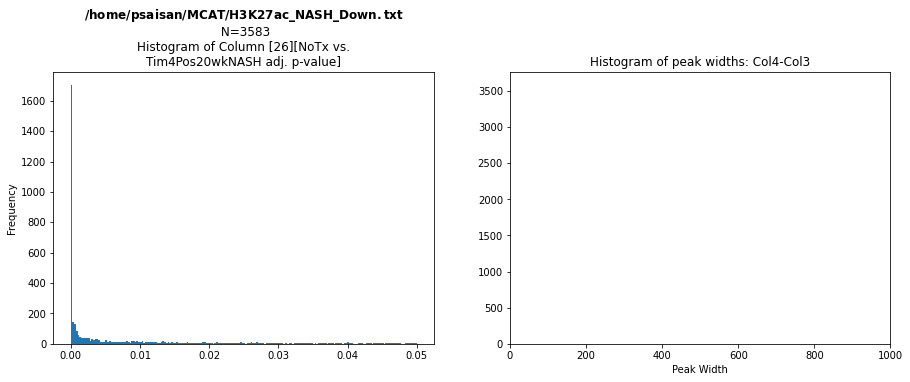

,[1][PeakID (cmd=annotatePeaks.pl mergePeaks_C57_NoTx_Tim4Pos20wkNASH.txt mm10 -raw -size 2000 -d c57_NoTx_Rep1 c57_NoTx_Rep2 c57_Tim4Pos20WkNASH_Rep1 c57_Tim4Pos20WkNASH_Rep2) (cmd=getDiffExpression.pl ann_H3K27AC_2000_mergePeaks_C57_NoTx_Tim4Pos20wkNASH_enhancer_3000.txt NoTx NoTx Tim4Pos20wkNASH Tim4Pos20wkNASH -peaks -simpleNorm -export getDiff_ann_H3K27AC_2000_mergePeaks_C57_NoTx_Tim4Pos20wkNASH_enhancer_3000)],[2][Chr],[3][Start],[4][End],[5][Strand],...,"[22][c57_Tim4Pos20WkNASH_Rep1 Tag Count in 2000 bp (18749728.0 Total, normalization factor = 1, effective total = 10000000)]","[23][c57_Tim4Pos20WkNASH_Rep2 Tag Count in 2000 bp (19231109.0 Total, normalization factor = 1, effective total = 10000000)]",[24][NoTx vs. Tim4Pos20wkNASH Log2 Fold Change],[25][NoTx vs. Tim4Pos20wkNASH p-value],[26][NoTx vs. Tim4Pos20wkNASH adj. p-value]
794,Merged-chr15-59643086-1,chr15,59642086,59644086,+,...,21.63,22.42,-1.20951542055803,0.0144079713019947,4.995457e-02
1359,Merged-chr13-34193499-2,chr13,34192499,34194499,+,...,16.92,20.47,-1.32835116394982,0.0143941086307104,4.992498e-02
2094,Merged-chr11-99074003-1,chr11,99073003,99075003,+,...,31.97,38.02,-1.02174521832834,0.0143114887246688,4.967061e-02
2792,Merged-chr5-92256705-1,chr5,92255705,92257705,+,...,7.52,9.75,-1.71157416043875,0.0142954310228063,4.961948e-02
3276,Merged-chr2-129630725-1,chr2,129629725,129631725,+,...,25.39,29.25,-1.11638569580939,0.0142919513654144,4.961763e-02
...,...,...,...,...,...,...,...,...,...,...,...
2854,Merged-chr17-67345344-2,chr17,67344344,67346344,+,...,69.58,97.50,-2.99511008380855,2.75325645890446e-37,2.578838e-34
1910,Merged-chr11-82570893-1,chr11,82569893,82571893,+,...,50.77,58.50,-3.27871042140405,2.73473868620099e-38,3.013521e-35
3572,Merged-chr13-89384897-2,chr13,89383897,89385897,+,...,97.79,83.85,-3.19573706571676,1.32215006351812e-40,2.063986e-37
88,Merged-chr11-46817904-1,chr11,46816904,46818904,+,...,22.57,23.40,-4.14739475077765,1.18774116188491e-40,1.934779e-37


In [91]:
displayPeak('/home/psaisan/MCAT/H3K27ac_NASH_Down.txt','[26]')

In [149]:
# 8
#############################
# SAVE cond1 and cond2 Peaks - we are going to look at 
# histograms Tag density as functino of distance from peak center

cond1_file=baseDir+f'./results/ATAC_diff_h3k27ac_peaks_UP_{Group1}.txt'
cond2_file=baseDir+f'./results/ATAC_diff_h3k27ac_peaks_UP_{Group2}.txt'
df2[cond1].to_csv(cond1_file, sep='\t', index=False)
df2[cond2].to_csv(cond2_file, sep='\t', index=False)


In [156]:
# 9
#############################

# NOW Create/plot peaks within a sub-segment defined by a specific condition
# Using HOMER's annotatePeaks -hist function

# Define histogram output table files
cond1_file_HIST = f'{baseDir}/results/HISTOGRAM_ATAC_diff_h3k27ac_peaks_UP_{Group1}.txt'
cond2_file_HIST = f'{baseDir}/results/HISTOGRAM_ATAC_diff_h3k27ac_peaks_UP_{Group2}.txt'

# Define inputs dynamically using exec() (not the best practice, but you're asking for it)
exec(f'tag_{Group1} = KC_H_Rep1')  # Creates tag_MASH = 'KC_H_Rep1'
exec(f'tag_{Group2} = KC_N_Rep1')  # Creates tag_HEALTHY = 'KC_N_Rep1'

# Now retrieve the dynamically created variables
tag1 = eval(f'tag_{Group1}')  # Equivalent to tag_MASH
tag2 = eval(f'tag_{Group2}')  # Equivalent to tag_HEALTHY

# Extract Histogram/density using the dynamically created variables in shell commands
# Note that you need to pass these variables into the command strings
!annotatePeaks.pl $cond1_file  mm10 -size 2000 -noann -d $tag1  -d  $tag2 -hist 20 > $cond1_file_HIST 
!annotatePeaks.pl $cond2_file  mm10 -size 2000 -noann -d $tag1  -d  $tag2 -hist 20 > $cond2_file_HIST 



	Peak file = /home/psaisan/MCAT/./results/ATAC_diff_h3k27ac_peaks_UP_MASH.txt
	Genome = mm10
	Organism = mouse
	Peak Region set to 2000
	Will Skip peak annotation
	Tag Directories:
		/home/psaisan/MCAT//data/ChIP_HEALTHY_Rep1
	Tag Directories:
		/home/psaisan/MCAT//data/ChIP_MASH_Rep1
	-----------------------------------------------------
	Histogram mode activated (bin size = 20 bp)
	-----------------------------------------------------
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 3717
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 3717
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	Reading Positions...
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ra

['#PeakID', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5', 'Column6']


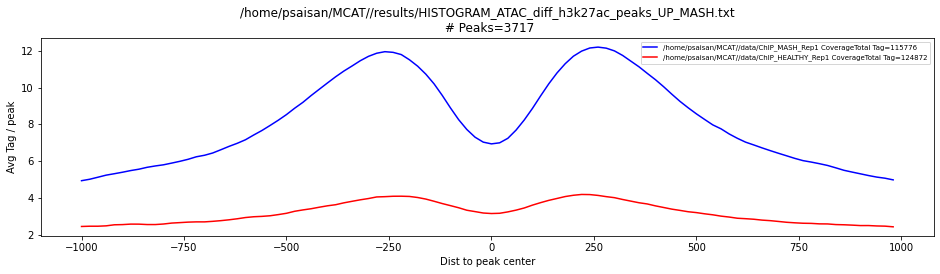

In [170]:
#PLOT H3K27AC Densities associated with last section's peak segments:
# 10
#############################

# PLOT Hist for cond1 peaks
H3K_peak_file=cond1_file
H3K_out_file =cond1_file_HIST


WT_Col=1
KO_Col=4;

df   = readPeak(H3K_out_file); 
df2 = readPeak(H3K_peak_file);

Xbins_Col=0

# Assuming 'df' is your DataFrame
# Extract the data from the desired column (column index 2 in this case)

xdata = df.iloc[1:-1, Xbins_Col]  # Replace 2 with the desired column index
xdata = pd.to_numeric(xdata, errors='coerce')
ydata = df.iloc[1:-1, KO_Col]  # Replace 2 with the desired column index
ydata = pd.to_numeric(ydata, errors='coerce')


zdata = df.iloc[1:-1, WT_Col]  # Replace 2 with the desired column index
zdata = pd.to_numeric(zdata, errors='coerce')
# Create a histogram using matplotlib

plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
plt.plot(xdata,ydata,'b',label=df.iloc[0,KO_Col] + 'Total Tag='+str(int(np.sum(pd.to_numeric(df2.iloc[:,20])))) )  # You can adjust the number of bins as needed
plt.plot(xdata,zdata,'r',label=df.iloc[0,WT_Col] + 'Total Tag='+str( int(np.sum(pd.to_numeric(df2.iloc[:,19]))))) # You can adjust the number of bins as needed

# Add labels and a title
plt.xlabel('Dist to peak center')  # Replace with your X-axis label
plt.ylabel('Avg Tag / peak')  # Replace with your Y-axis label
plt.title(H3K_out_file+'\n # Peaks='+str(len(df2))) # Replace with your desired title
plt.legend(loc='upper right',fontsize=7)

# Show the histogram
plt.show()



['#PeakID', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5', 'Column6']


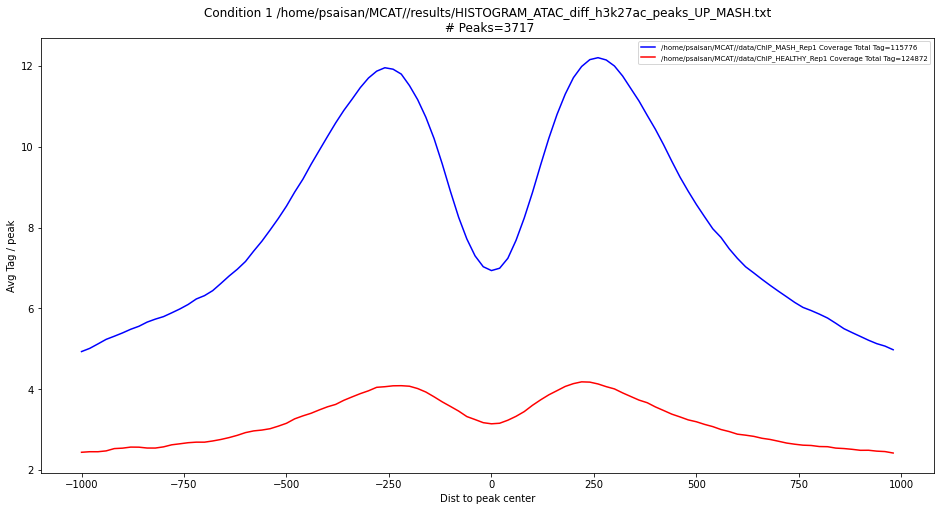

['#PeakID', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5', 'Column6']


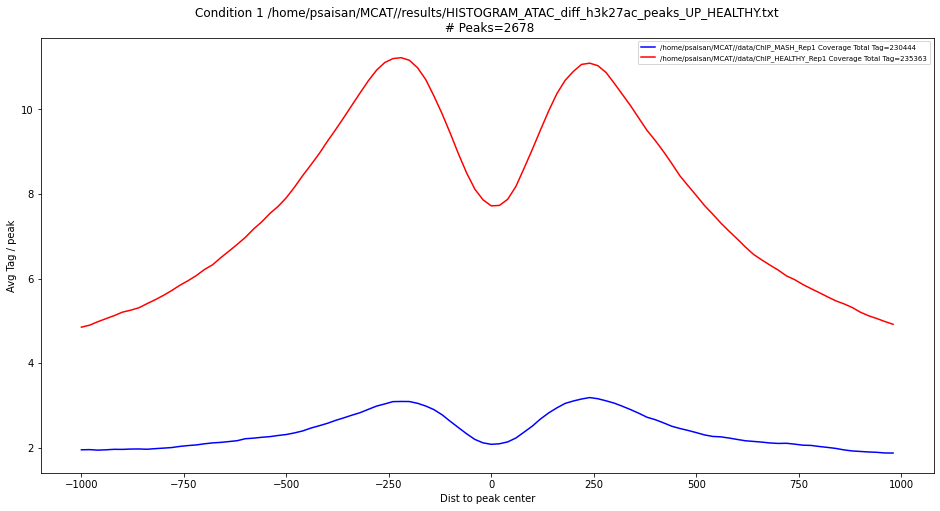

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the plotting function
def plot_hist(df, df2, Xbins_Col, KO_Col, WT_Col, H3K_out_file, title_prefix):
    # Extract xdata, ydata, zdata for plotting
    xdata = df.iloc[1:-1, Xbins_Col]
    xdata = pd.to_numeric(xdata, errors='coerce')
    ydata = df.iloc[1:-1, KO_Col]
    ydata = pd.to_numeric(ydata, errors='coerce')
    zdata = df.iloc[1:-1, WT_Col]
    zdata = pd.to_numeric(zdata, errors='coerce')
    
    # Create the plot
    plt.plot(xdata, ydata, 'b', label=df.iloc[0, KO_Col] + ' Total Tag=' + str(int(np.sum(pd.to_numeric(df2.iloc[:, 20])))))
    plt.plot(xdata, zdata, 'r', label=df.iloc[0, WT_Col] + ' Total Tag=' + str(int(np.sum(pd.to_numeric(df2.iloc[:, 19])))))

    # Add labels and title
    plt.xlabel('Dist to peak center')
    plt.ylabel('Avg Tag / peak')
    plt.title(f'{title_prefix} {H3K_out_file}\n # Peaks={str(len(df2))}')
    plt.legend(loc='upper right', fontsize=7)

# Main part to call the plotting function for two DataFrames
# Define variables for condition 1
H3K_peak_file = cond1_file
H3K_out_file= cond1_file_HIST
WT_Col = 1
KO_Col = 4
Xbins_Col = 0

# Read the data for cond1
df1 = readPeak(H3K_out_file);
df2 = readPeak(H3K_peak_file);
# Create the figure and plot the histograms
plt.figure(figsize=(16, 8))
plot_hist(df1, df2_1, Xbins_Col, KO_Col, WT_Col, H3K_out_file, "Condition 1")
plt.show()



# Define variables for condition 1
H3K_peak_file = cond2_file
H3K_out_file= cond2_file_HIST
WT_Col = 1
KO_Col = 4
Xbins_Col = 0

# Read the data for cond2
df1 = readPeak(H3K_out_file)
df2 = readPeak(H3K_peak_file)
# Create the figure and plot the histograms
plt.figure(figsize=(16, 8))
plot_hist(df1, df2, Xbins_Col, KO_Col, WT_Col, H3K_out_file, "Condition 1")
plt.show()